# Rescaling bug

So with the davids_stool_A data. When doing the linear fit on the same portion but just rescaled yields other fit results. This should not be the cases since we have rigourously shown that with our estimator method, rescaling should only rescale the infered parameters but not completly change it. And certaintly not change the inferred p-value.

-----
Adapt the code such that we can now also generate steady states not centered at 1's.

To do this we will first still generate the interaction matrix (with self interaction) according to normal with the interaction strength and then rescale the matrix elements to the steadystate.

-> So basically we generate the scaled one and then transform it to the unscaled one.

We showed generally before: $\mathcal{O}(\hat{\beta})=-\mathcal{O}(X^T)$. Meaning we devide by that what we multiply our $X$ with. We scale our $X$ with inverse steady state-> such that it becomes(1 1), or in other words the effect is that we multiply our Beta column vectors by the steady state. To go the normalised version. (this is also btw what we saw before)

Or to now go from the normalised version to the scaled version we need to divide by the steady state!.

In [33]:
### Auto reloading moduls
%load_ext autoreload
%autoreload 2

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from helpFunctions import *
from generateGLV import *
from fitGLV import *
from mpl_toolkits.mplot3d import Axes3D
import time

In [5]:
import numpy as np

In [1]:
testDict = {"A":1, "B":2}
testDict["A"]

1

In [2]:
try:
    test = testDict["T"]
except:
    print("Jup")

Jup


In [10]:
test  = np.arange(4*3).reshape((4,3))
test

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [20]:
array = np.arange(4,dtype = float)

In [21]:
(test.T * array**-1).T

/home/lennart/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  """Entry point for launching an IPython kernel.
/home/lennart/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


array([[       nan,        inf,        inf],
       [3.        , 4.        , 5.        ],
       [3.        , 3.5       , 4.        ],
       [3.        , 3.33333333, 3.66666667]])

In [28]:
np.append(1,array)

array([1., 0., 1., 2., 3.])

In [53]:
# Default
noiseSetting = {
    "noiseType" : "LangevinLinear",
    "noiseStrength" : 0.02
}
pertuSetting = {
    "period" : 1000,
    "strenght" : 0.05
}
genSetting = {
    "interactionStrenght" : 0.05,
    "scaled":False,
    "steadystate": np.array([2,2,2,2,2])
}
numberSpecies = 5
numberExperiments = 3  

TS =  TS_GLV(numberSpecies,numberExperiments,noiseSetting,genSetting,pertuSetting)
TS.generate()

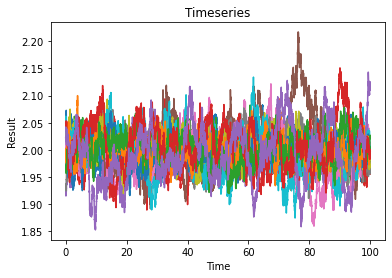

In [46]:
TS.plot()

-----------

Now fit the GLV data.

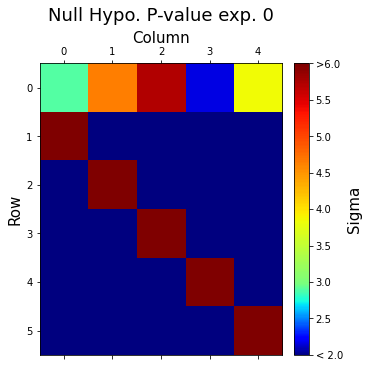

In [47]:
fitAll2 = fitGLV(TS)
fitAll2.computeNullHypo()
fitAll2.plotNullHypo()

--------

Now scale the data:

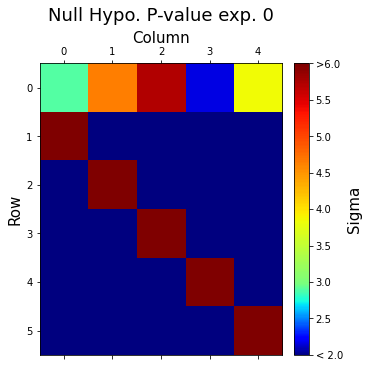

In [55]:
#TS.result = TS.result/2
fitScaled = fitGLV(TS)
fitScaled.computeNullHypo()
fitScaled.plotNullHypo()

-> We see that the p-value is the same!. Let's have a look at the fitted values:

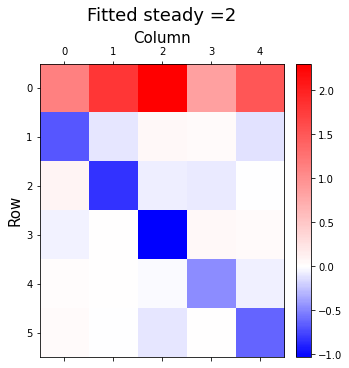

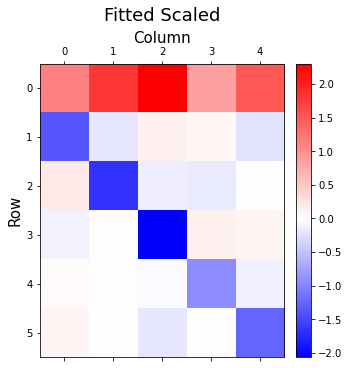

In [59]:
plotM(fitAll2.BEst[0],"Fitted steady =2", mode="PosNeg")
plotM(fitScaled.BEst[0],"Fitted Scaled", mode="PosNeg")

In [60]:
print("At 2:")
print(fitAll2.BEst[0])
print("Scaled:")
print(fitScaled.BEst[0])

At 2:
[[ 1.14055033  1.80764829  2.30612241  0.85639611  1.52961288]
 [-0.68044339 -0.10169549  0.06692925  0.04019297 -0.12101336]
 [ 0.09235046 -0.82496131 -0.0709557  -0.0886577  -0.00381815]
 [-0.05218973  0.0090904  -1.03279381  0.0677398   0.04664484]
 [ 0.02023922  0.01755863 -0.0166873  -0.46639789 -0.05766096]
 [ 0.05106953 -0.0033733  -0.09914018  0.01700446 -0.62798731]]
Scaled:
[[ 1.14055033  1.80764829  2.30612241  0.85639611  1.52961288]
 [-1.36088677 -0.20339099  0.1338585   0.08038594 -0.24202671]
 [ 0.18470091 -1.64992262 -0.14191139 -0.1773154  -0.00763631]
 [-0.10437946  0.01818079 -2.06558761  0.1354796   0.09328967]
 [ 0.04047843  0.03511726 -0.03337459 -0.93279579 -0.11532192]
 [ 0.10213906 -0.0067466  -0.19828035  0.03400892 -1.25597463]]


It looks correct, At the scaled version it is correctly multiplied by 2.

Infact, this is correct with all the elements:

In [63]:
np.any(fitAll2.BEst[0][1:]*2!=fitScaled.BEst[0][1:])

False

And all the p-values are exactly the same:

In [64]:
np.any(fitAll2.pNull!=fitScaled.pNull)

False

So indeed, rescaling does not effect the p-values. So what went then wrong with the real experimental data?

Lets revisit that case:


Extract the data

In [65]:
x = pd.read_csv('InputData/NewDavid_Data/25_timeseries.txt', na_values='NAN', delimiter='\t', header=None)
TSDavidA = x.T.values

Flag the pertubations:

In [66]:
PertuAll = np.full(len(TSDavidA)-1,False)
PertuAll[73:125]=True
PertuAll[260:273]=True
PertuAll[195:205]=True
TSPertuAll = np.append(PertuAll,False)

Remove the species with zero abundancy outside the pertubation zone.

In [67]:
BadSpeciesAll = np.unique(np.where(TSDavidA[~TSPertuAll]==0)[1],return_counts=True)
TSDavidA_GoodSpecies= np.delete(TSDavidA,BadSpeciesAll[0],axis=1)

Create a scaled version:

In [70]:
steadystate = np.median(TSDavidA_GoodSpecies[~TSPertuAll],axis = 0)
TSDavidA_GoodScaled = TSDavidA_GoodSpecies/steadystate

In [87]:
np.any((TSDavidA_GoodScaled*steadystate - TSDavidA_GoodSpecies) > 1e-10)

False

/home/lennart/Dropbox/VUB/2Ma Physics and Astronomy/MasterThesis/GitCode/PostFWO/fitGLV.py:174: RuntimeWarning: divide by zero encountered in log
  dln = np.diff(np.log(self.TS), axis=0)
/home/lennart/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:1269: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


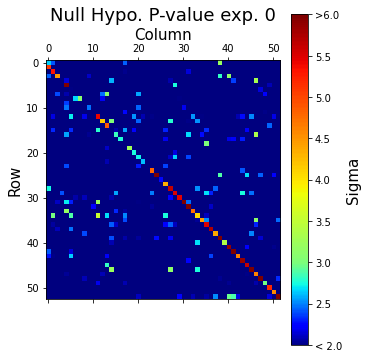

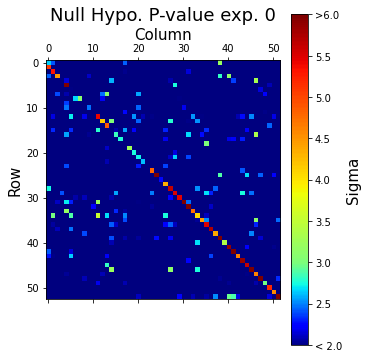

In [88]:
fitNormal = fitGLV({"TS":TSDavidA_GoodSpecies,"pertu":PertuAll}, typeInput="Experiment")
fitScaled = fitGLV({"TS":TSDavidA_GoodScaled,"pertu":PertuAll}, typeInput="Experiment")
fitNormal.computeNullHypo()
fitScaled.computeNullHypo()
fitNormal.plotNullHypo()
fitScaled.plotNullHypo()

-> It does seem that when plotting all the data it seems to be correct! 

In [90]:
np.any(fitNormal.pNull - fitScaled.pNull > 1e-10)

False

In [105]:
np.any((fitNormal.BEst[0,1:].T * steadystate).T - fitScaled.BEst[0,1:] > 1e-10)

False

So what was the problem then? Before I took the first 10. Lets do that again.

/home/lennart/Dropbox/VUB/2Ma Physics and Astronomy/MasterThesis/GitCode/PostFWO/fitGLV.py:174: RuntimeWarning: divide by zero encountered in log
  dln = np.diff(np.log(self.TS), axis=0)
/home/lennart/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:1269: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


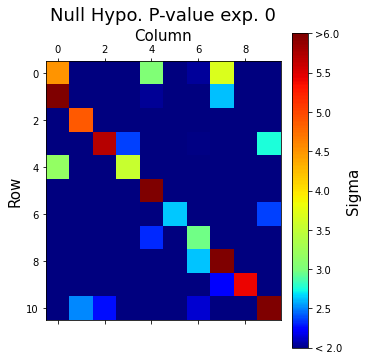

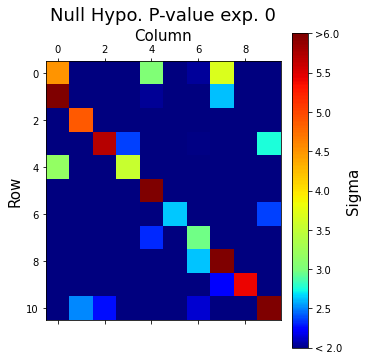

In [107]:
first10_UnScaled = TSDavidA_GoodSpecies[:,:10]
first10_Scaled = TSDavidA_GoodScaled[:,:10]
fitNormal10 = fitGLV({"TS":first10_UnScaled,"pertu":PertuAll}, typeInput="Experiment")
fitScaled10 = fitGLV({"TS":first10_Scaled,"pertu":PertuAll}, typeInput="Experiment")
fitNormal10.computeNullHypo()
fitScaled10.computeNullHypo()
fitNormal10.plotNullHypo()
fitScaled10.plotNullHypo()

-> We see agian in both cases the same result. And it seems that before the unscaled version was fitted wrongly? Or something.

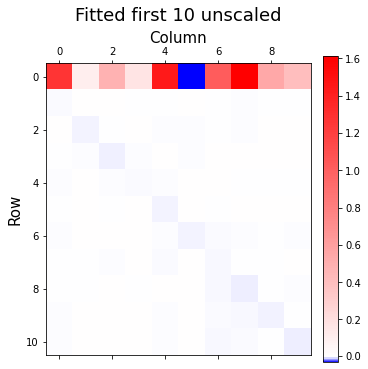

In [110]:
plotM(fitNormal10.BEst[0],"Fitted first 10 unscaled", mode="PosNeg")

-> Uh, the fit that we get is different! As before? What has changed?

Ok, now I understand we just took different species before:

We had not reorder our data in the scaled. While in the unscaled version we had. 

-> So in the end everything is ok :)